In [ ]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data processing

Data extection and understanding

In [ ]:
data_path = '/content/drive/MyDrive/temp_project/data'

In [ ]:
images_name = os.listdir(data_path)

In [ ]:
input_images_name_extension = ".png"
output_images_name_extension = ".jpg"

In [ ]:
images_name_without_extension = list(set([name[:-4] for name in images_name]))

collecting information of images

In [ ]:
sample_input_image = plt.imread(os.path.join(data_path,(images_name_without_extension[0]+input_images_name_extension)))
sample_output_image = plt.imread(os.path.join(data_path,(images_name_without_extension[0]+output_images_name_extension)))

In [ ]:
sample_input_image.shape,sample_output_image.shape

((421, 590, 3), (421, 590, 3))

In [ ]:
sample_input_image.dtype,sample_output_image.dtype

(dtype('float32'), dtype('uint8'))

In [ ]:
np.max(sample_input_image),np.max(sample_output_image)

(1.0, 255)

In [ ]:
np.min(sample_input_image),np.min(sample_output_image)

(0.0, 0)

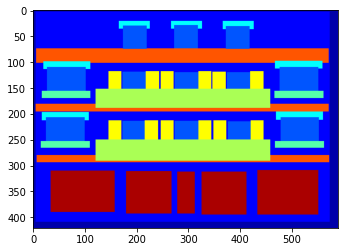

In [ ]:
plt.imshow(sample_input_image)

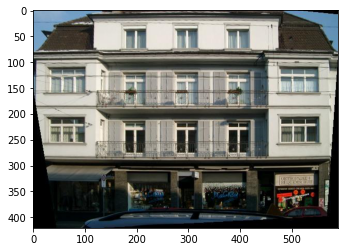

In [ ]:
sample_output_image = sample_output_image.astype(np.float32)
sample_output_image /= 255.0
plt.imshow(sample_output_image)

data preprocessing and making of dataset

In [ ]:
input_images_path = [os.path.join(data_path,name+input_images_name_extension) for name in images_name_without_extension]
output_images_path = [os.path.join(data_path,name+output_images_name_extension) for name in images_name_without_extension]

In [ ]:
checker = []
for i in range(len(input_images_path)):
  checker.append((input_images_path[i])[:-4] == (output_images_path[i])[:-4])
  if i==0:
    print(checker)

print(f"input file path and output file path in order ?")
print(f"{all(checker)}")

[True]
input file path and output file path in order ?
True


In [ ]:
BATCH_SIZE = 16
IMG_SIZE  =  64

In [ ]:
def map_image(input_image_path,output_image_path):
  input_image = tf.io.read_file(input_image_path)
  output_image = tf.io.read_file(output_image_path)

  input_image = tf.image.decode_png(input_image)
  output_image = tf.image.decode_jpeg(output_image)

  input_image = tf.cast(input_image , dtype=tf.float32)
  output_image = tf.cast(output_image , dtype=tf.float32)
  
  input_image = tf.image.resize(input_image,(IMG_SIZE,IMG_SIZE))
  output_image = tf.image.resize(output_image,(IMG_SIZE,IMG_SIZE))

  input_image = input_image/255.0
  output_image = tf.clip_by_value(output_image,0.0,255.0)

  return input_image,output_image 

In [ ]:
sample_input_image,sample_output_image = map_image(input_images_path[0],output_images_path[0])

In [ ]:
sample_input_image.shape,sample_output_image.shape,np.max(sample_input_image),np.max(sample_output_image),np.min(sample_output_image)

(TensorShape([64, 64, 3]), TensorShape([64, 64, 3]), 1.0, 252.61255, 0.0)

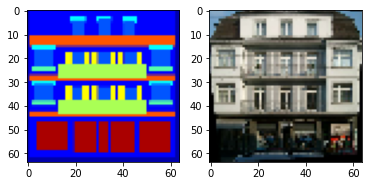

In [ ]:
plt.subplot(1,2,1)
plt.imshow(sample_input_image)
plt.subplot(1,2,2)
plt.imshow(sample_output_image/255.0)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_images_path,output_images_path))

dataset = dataset.map(map_image).batch(BATCH_SIZE)

#Building Model

In [ ]:
'''U_net will be used for generator'''

'U_net will be used for generator'

In [ ]:
from tensorflow.keras.layers import Conv2D , Conv2DTranspose, BatchNormalization,Activation,MaxPool2D,Input,Concatenate,Lambda,LeakyReLU,Dropout,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

In [ ]:

def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def build_unet(input_shape):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)
  outputs = Lambda(lambda x : x * 255.0)(outputs)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  return model




In [ ]:
# # define the standalone generator model
# def define_generator(image_shape=(256,256,3)):
#   in_image=Input(shape=image_shape)
#   e1 = define_encoder_block(in_image, 64, batchnorm=False)
#   e2 = define_encoder_block(e1, 128)
#   e3 = define_encoder_block(e2, 256)
#   e4 = define_encoder_block(e3, 512)
#   e5 = define_encoder_block(e4, 512)
#   b = Conv2D(512, (4,4), strides=(2,2), padding='same')(e5)
#   b = Activation('relu')(b)
#   d3 = decoder_block(b, e5, 512)
#   d4 = decoder_block(d3, e4, 512, dropout=False)
#   d5 = decoder_block(d4, e3, 256, dropout=False)
#   d6 = decoder_block(d5, e2, 128, dropout=False)
#   d7 = decoder_block(d6, e1, 64, dropout=False)
#   g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same')(d7)
#   out_image = Activation('tanh')(g)
#   # out_image = Lambda(lambda x : (x * 255.0) )(out_image)
#   model = Model(in_image, out_image)
#   return model

In [ ]:
generator = build_unet((IMG_SIZE,IMG_SIZE,3))

In [ ]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 64, 64, 64)   256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 64, 64, 64)   0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [ ]:
'''Now in image-to-image processing discriminator should take two inputs one is input_image and other is output_image(fake or real) then concatenate it and then results are predicted'''

'Now in image-to-image processing discriminator should take two inputs one is input_image and other is output_image(fake or real) then concatenate it and then results are predicted'

In [ ]:
def define_discriminator(image_shape):
  init = RandomNormal(stddev=0.02)
  in_src_image = Input(shape=image_shape)
  in_target_image = Input(shape=image_shape)
  merged = Concatenate()([in_src_image, in_target_image])
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(1, (4,4), padding='valid', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  model = Model([in_src_image, in_target_image], patch_out)
  return model

In [ ]:
discriminator = define_discriminator((IMG_SIZE,IMG_SIZE,3))

In [ ]:
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 64, 64, 6)    0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 32, 32, 64)   6208        concatenate_8[0][0]        

In [ ]:
def define_gan(g_model,d_model,image_shape=(IMG_SIZE,IMG_SIZE,3)):
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  inputs = Input(shape=image_shape)
  fake_out = g_model(inputs)
  d_out = d_model([inputs,fake_out])
  model = Model(inputs,[d_out,fake_out])
  return model

In [ ]:
gan = define_gan(generator,discriminator)

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False
gan.compile(loss=[tf.keras.losses.binary_crossentropy,tf.keras.losses.mean_squared_error], optimizer="adam")

In [ ]:
gan.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 64, 64, 3)    31055427    input_5[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1, 1, 1)      6968257     input_5[0][0]                    
                                                                 model_1[0][0]                    
Total params: 38,023,684
Trainable params: 38,009,092
Non-trainable params: 14,592
__________________________________________________________________________________________________


#model Training

In [ ]:
def train_gan(gan, dataset, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the g_model and d_model
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the g_model
      n_epochs -- number of epochs
    """
    (_,g_model, d_model) = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for step,(input_images,output_images) in enumerate(dataset):
            # infer batch size from the training batch
            batch_size = output_images.shape[0]

            # use the noise to generate fake images
            fake_images = g_model(input_images)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, output_images], axis=0)

            mixed_input_images = tf.concat([input_images,input_images],axis=0)

            # Create the labels for the d_model
            # 0 for the fake images
            # 1 for the real images
            current_batch_size = input_images.shape[0]
            d_model_labels_fake =  tf.zeros( shape=(current_batch_size,1,1,1))
            d_model_labels_real = tf.ones( shape=(current_batch_size,1,1,1))
            d_model_labels = tf.concat([d_model_labels_fake,d_model_labels_real],axis=0)
            
            
            # ensure that the d_model is trainable)
            d_model.trainable = True

            # use train_on_batch to train the d_model with the mixed images and the d_model labels
            d_loss = d_model.train_on_batch([mixed_input_images,mixed_images], d_model_labels)

            # Train the g_model - PHASE 2
            
            
            # label all generated images to be "real"
            g_model_labels = tf.ones( shape=(current_batch_size,1,1,1))

           
          
            # train the GAN on the noise with the labels all set to be true
            g_loss = gan.train_on_batch(input_images, [g_model_labels,output_images])

        print(f"{epoch} : g_loss = {g_loss} , d_loss = {d_loss} ")
 

In [ ]:
train_gan(gan,dataset,50)

Epoch 1/50
0 : g_loss = [110.895751953125, 0.33783313632011414, 110.55792236328125] , d_loss = 0.4436967968940735 
Epoch 2/50
1 : g_loss = [104.71067810058594, 0.31478151679039, 104.3958969116211] , d_loss = 0.4306102693080902 
Epoch 3/50
2 : g_loss = [111.3725357055664, 0.37343281507492065, 110.99909973144531] , d_loss = 0.5945456027984619 
Epoch 4/50
3 : g_loss = [111.5003890991211, 0.26057833433151245, 111.23980712890625] , d_loss = 0.7669342756271362 
Epoch 5/50
4 : g_loss = [112.45738220214844, 0.2697162628173828, 112.18766784667969] , d_loss = 0.6590894460678101 
Epoch 6/50
5 : g_loss = [120.20790100097656, 0.19472885131835938, 120.01316833496094] , d_loss = 0.6382293701171875 
Epoch 7/50
6 : g_loss = [118.95890808105469, 0.2982720732688904, 118.66064453125] , d_loss = 0.5662862062454224 
Epoch 8/50
7 : g_loss = [124.646728515625, 0.3233451247215271, 124.3233871459961] , d_loss = 0.6440497636795044 
Epoch 9/50
8 : g_loss = [133.5223846435547, 0.5209528207778931, 133.0014343261718

In [ ]:
sample_input_image = tf.reshape(sample_input_image,(1,64,64,3))

In [ ]:
d_out,fake_output = gan.predict(sample_input_image)

In [ ]:
d_out

array([[[[0.15186927]]]], dtype=float32)

In [ ]:
np.max(fake_output)

233.12985

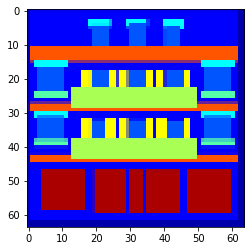

In [ ]:
plt.imshow(tf.reshape(sample_input_image,(64,64,3)))

In [ ]:
display_image = fake_output 

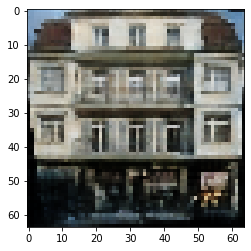

In [ ]:
plt.imshow(display_image.squeeze()/255.0)